# Submitted by:
 
* Name 1: Ido Hayun
* Name 2: Lidor Tevet
* Name 3: Tim Buchbinder


# paint_the_circle Project

This project identifies and paints circles given in RGB images. Specifically, each input image contains a rectangle, a triangle and a circle. The image is fed into a neural netork, whose outputs are the center and radius of the circle within the image. The domain considered is "[0,1]x[0,1] "box". PyTorch is the platform used. The goal is to paint the circle.

### **You are given the following files:**
  Three directories named "train", "validation", and "test" each containing the following:
  1. a directory called "images" with RGB png files of size 128x128 (so image that is read has shape (3,128,128))
  2. a file "labels.txt" containing the center points (as x,y) and radius of the circles for all images in "images" directory

Since this problem is somewhat open ended, you are given a suggested structure and some functionality that is already implemented for you (see below). You are not at all obigated to follow this structure or use the code given. 

**Note:** 
- "network" and "model" are used interchangeably throughout this documentation.
 
 
### **General structure (in order):**
 1. DataSet and DataLoader            - this is how you load data into the network **(given to you)**
 2. Neural Network definition         - the class that defines your model   **(need to implement)** //from the file (first try)
 3. calculate model parameters number - useful to get a feel for network's size **(given to you)**
 4. loss function definition          - to be used in training **(need to implement)* 
 5. create an optimizer               - choose your optimizer **(need to implement)** start with adam
 6. estimate number of ops per forward feed - the bigger this is the slower the training **(given to you)**
 7. estimate ops per forward feed     - use function given to you to estimate this **(implement for convenience)** // ido
 8. view images and target and net labels - example code to help you see how to use loaders **(given to you)**
 9. validate_model                   - returns avg loss per image for a model and loader  **(need to implement)**
 10. train_model                      - trains the network **(need to implement)**
 11. plot train/validaion losses      - visualizing train and validation losses from training **(given to you)**
 12. save/load model                  - Allows you to save and load model to disk for later use **(given to you)**
 13. visualizing images    - Painting circles prodiced by network on images from a given loader **(given to you)**
 
 
### ** What you need to do **
You have 5 (and a half...) things to do:
 1. Create a CircleNet class, which is your network model. This is a key component. The output of your model should be 3 numbers that represent the the center and radius of the circle in the input image fed into your network. You should keep in mind the number of parameters in your model. If there are too many, it may overfit (and take longer to run). If there are too few, you it may not be able to learn the task needed. A typical structure would have convolutional layers first and fully connected at the end, thus reducing number of parameteres. Consider which activation function you want to use, and whether or not you wish to use batch normalization or dropout. Pooling layers are also possible. Be creative.
 
 2. Create a loss function. This is another key component as it defines what it means for two circles (the true circle and its estimation) to be similar or not. Namely, two circles (represented by two centers and two radii: ground truth ("labels") and network outputs ("outputs")), whose images look similar should have a smaller loss than two circles whose images look less simialr. Think about how you would quantify "closeness"/"similarity" of circles.

 3. Choose an optimizer. Look here for some ideas: https://pytorch.org/docs/master/optim.html
 
 4. (This is the "half" thing to do). For your conveinece you may want to use the function calc_ops() that is given to you to calculate an estimate of the number of operations that your network does per feed forward. To do this, you need to enter your own network structure. An example of an arbitrary network is privided to you.
 
 5. Create a validate_model function that assesses (tests) the performance of a model. It returns the average loss per image for a given loader. It can be run on any set of data (train, validation, or test). You may want to run this function on validation set (loader) from within the train function (see below) train after each epoch so as to see how loss behaves on validation during the training process.
 
 6. Create a train_model function that trains model. This function updates the following parameteres: model, train_losses, and validation_losses. Model is updated simply by the training processes when optimzer.step() is called. The other two parameteres are lists that hold the average loss per image for the corresponding data (train or validation). After every epoch (i.e., iteration that goes over the entire train data), you should save to these lists the average loss per image for the corresponding data loader. These lists are useful in that you can plot them (functionality given to you) and observe how model behaves. Observe: this fucnton returs nothing, however, it updates parameteres by reference. Specifically, model is updated (trained), and so are train and validation losses values.
 
**Note:** You are given three sets of data: trian, validation, and test. It is recommended that test not be touched until the very end, and validation be used to get a sense of your network's performance. 

### ** Running on a GPU: **
It is not necessary to use a GPU for this project. However, if you choose to do so, you will gain a major speedup to your training, which will save you much time. The code given to you identifies the hardware used and will  automatically run on either a GPU or CPU. 

### ** Useful links: **
1. PyTorch master tutorial - VERY useful: https://pytorch.org/docs/master/nn.html
2. PyTorch optimizers: https://pytorch.org/docs/master/optim.html
3. A list of possible reasons why things go wrong: https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607#74de

### ** Final tips: **
Use the Internet! Things will not work first time. You will get strange error messages. Google them up. The web is  great resource for tackling problems ranging from python error messages, to things not doing what you'd like them to do.


### ** Submission Instructions**
The project is to be submittd in teams as in the homework. You need to submit the following three files:
1. model.dat                            - This is your saved model 
2. paint_that_circle.ipynb              - This is this notebook containing all of your work
3. model.py                             - A file containing your CircleNet class only. 

Before you submit, run "check_before_submission.ipynb" to make sure your model could be properly tested. See instructions for running this notebook inside.

Make sure your names appear at the top of this notebook in the appropriate place.

### **GOOD LUCK!**

In [1]:
import numpy as np
import PIL.Image as Image
from PIL import ImageDraw

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os
import glob
import datetime

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Dataset class definition (given to you) 

In [2]:
class ShapesDataset(Dataset):
    
    def __init__(self, dataset_dir):
        """
        Initializing dataset by generating a dicitonary of labels, where an image file name is the key 
        and its labels are the contents of that entry in the dictionary. Images are not loaded. This way it
        is possible to iterate over arbitrarily large datasets (limited by labels dicitonary fitting 
        in memory, which is not a problem in practice)
        
        Args:
            dataset_dir : path to directory with images and labels. In this directory we expect to find
                          a directory called "images" containing the input images, and a file called 
                          "labels.txt" containing desired labels (coefficients)
        """
        
        self.dataset_dir = dataset_dir
        self.labels_dict = self.gen_labels_dict()
        self.images_keys = list(self.labels_dict)  # getting the keys of the dictionary as list
        self.images_keys.sort()                    # sorting so as to have in alphabetical order 

    def __len__(self):
        return len(self.labels_dict)

    def __getitem__(self, index):    
        """
        This funtion makes it possible to iterate over the ShapesDataset
        Args:
            index: running index of images
            
        Returns:
            sample: a dicitionary with three entries:
                    1. 'image'  contains the image
                    2. 'labels' contains labels (coeffs) corresponding to image
                    3. 'fname'  contains name of file (image_key) - may be useful for debugging
        """
        image_key = self.images_keys[index]     # recall - key is the file name of the corresponding image
        image = np.array(Image.open(image_key)) # image has shape: (128, 128, 3)
        image = image/255.0                     # simple normalization - just to maintain small numbers
        image = np.transpose(image, (2, 0, 1))  # network needs RGB channels to be first index
        labels = self.labels_dict[image_key]
        sample = {'image': image, 'labels': labels, 'fname':image_key}
        
        return sample
    
    
    def gen_labels_dict(self):
        """
        This fucntion generates a dictionary of labels
        
        Returns:
            labels_dict: the key is image file name and the value is the corresponding 
            array of labels  
        """
        
        labels_fname = self.dataset_dir + "/labels.txt"
        labels_dict = {}
        with open(labels_fname, "r") as inp:
            for line in inp:
                line = line.split('\n')[0]                                      # remove '\n' from end of line 
                line = line.split(',')
                key  = self.dataset_dir + '/images/' + line[0].strip() + ".png" # image file name is the key
                del line[0]
                
                list_from_line = [float(item) for item in line]
                labels_dict[key] = np.asarray(list_from_line, dtype=np.float32)
                        
        return labels_dict             


# Create Data Loaders (given to you) 

In [3]:
train_dir      = "./train/"
validation_dir = "./validation/"
test_dir       = "./test/"


train_dataset = ShapesDataset(train_dir)

train_loader = DataLoader(train_dataset, 
                          batch_size=32,
                          shuffle=True)



validation_dataset = ShapesDataset(validation_dir)

validation_loader = DataLoader(validation_dataset, 
                               batch_size=1,
                               shuffle=False)



test_dataset = ShapesDataset(test_dir)

test_loader = DataLoader(test_dataset, 
                          batch_size=1,
                          shuffle=False)


print("train loader examples     :", len(train_dataset)) 
print("validation loader examples:", len(validation_dataset))
print("test loader examples      :", len(test_dataset))

train loader examples     : 1000
validation loader examples: 100
test loader examples      : 100


# Neural Network class definition

In [4]:
class CircleNet(nn.Module):    # nn.Module is parent class  
    def __init__(self):
        super(CircleNet, self).__init__()  #calls init of parent class
                

        #----------------------------------------------
        self.conv1_1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3)
        # self.conv1_2_batch = nn.BatchNorm2d(16)
        self.conv2_1 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size=3)
        # self.conv2_2_batch = nn.BatchNorm2d(32)
        self.conv3_1 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size=4)
        self.fc1 = nn.Linear(12 * 12 * 64, 100)
        # self.fc1 = nn.Linear(29 * 29 * 32, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 3)
        #----------------------------------------------   
        # the net is bit complicated but we tried a few networks ( simpler ones too )
        # and this net provided the best results (+5% accuracy)
                
    def forward(self, x):
        """
        Feed forward through network
        Args:
            x - input to the network
            
        Returns "out", which is the network's output
        """
        
        #----------------------------------------------

        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        #x = self.conv1_2_batch(x)
        x = F.max_pool2d(x,2)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        #x = self.conv2_2_batch(x)
        x = F.max_pool2d(x,2)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.max_pool2d(x,2)
        x = x.view(-1, 12 * 12 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x) 
        x = F.relu(x)
        out = x
       
        return out                
             
             
   

# Loss function definition

In [5]:
def my_loss(outputs, labels):
    
    """
        Args:
        outputs - output of network ([batch size, 3]) 
        labels  - desired labels  ([batch size, 3])
    """
    
    loss = torch.zeros(1, dtype=torch.float, requires_grad=True)
    loss = loss.to(device)
    
    #----------------------------------------------
    # implementation needed here 
    
    batchsize = outputs.shape[0]
    accuracy = 0
    for i in range(batchsize):
        x1,y1,r1 = outputs[i]
        x2,y2,r2 = labels[i]
        accuracy += calculate_percents(outputs[i], labels[i]) #- for our training
        loss = loss + (((((x1 - x2)**2) + ((y1 - y2)**2))**(0.5)) * 2) + abs(r1 - r2)
                
    loss = loss / batchsize

    # Observe: If you need to iterate and add certain values to loss defined above
    # you cannot write: loss +=... because this will raise the error: 
    # "Leaf variable was used in an inplace operation"
    # Instead, to avoid this error write: loss = loss + ...  
    
                                      
    return (loss, accuracy)

from scipy.optimize import brentq

def calculate_percents(computer_circle, target_circle):
    x1,y1,r1 = computer_circle
    x2,y2,r2 = target_circle
    distanst = math.sqrt(((x1 - x2)**2) + ((y1 - y2)**2))
    intarea = intersection_area(distanst, r1, r2)
    area1 = math.pi * r1**2
    area2 = math.pi * r2**2
    percents = ((intarea/area1) + (intarea/area2)) / 2
    return percents

def intersection_area(d, R, r):
    """Return the area of intersection of two circles.

    The circles have radii R and r, and their centres are separated by d.

    """
    # One circle is entirely enclosed in the other.
    if d <= abs(R-r):   
        return np.pi * min(R, r)**2
    
    # The circles don't overlap at all.
    if d >= r + R:
        return 0

    r2, R2, d2 = r**2, R**2, d**2
    alpha = math.acos((d2 + r2 - R2) / (2*d*r))
    beta = math.acos((d2 + R2 - r2) / (2*d*R))
    return ( r2 * alpha + R2 * beta -
             0.5 * (r2 * math.sin(2*alpha) + R2 * math.sin(2*beta)) )

# Get number of trainable parameters (given to you)  

In [6]:
def get_train_params_num(model):
    """
    This fucntion returns the number of trainable parameters of neural network model
    You may want to call it after you create your model to see how many parameteres the model has
    Args:
        model - neural net to examine
    """
    
    #filter given iterable with a function that tests each element in the iterable to be true or not
    model_parameters = filter(lambda p: p.requires_grad == True, model.parameters()) 
    params_num = sum([np.prod(p.size()) for p in model_parameters])
    return params_num


# Model creation and choice of optimizer

In [7]:
model = CircleNet().to(device)
print ("Number of model trainable parameters:", get_train_params_num(model))

#----------------------------------------------
optimizer = torch.optim.Adam(model.parameters())
#----------------------------------------------



Number of model trainable parameters: 1023495


# Get an estimate number of operations (given to you)

In [8]:
def calc_ops(inp_size, net_struct):
    """
    Calculates a rough number of operations for a given network topology
    Args:
        inp_size - (W,H) of input 
        net_struct - list of tuples describing structure of network. 
        
        Example:
         (('conv2d', (3, 8, 3, 1, 0)),  # cin, cout, kernel, stride, pad
          ('conv2d': 83, 8, 3, 1, 0)),
          ('MaxPool2d', (2,2)),         # kernel, stride
          ('fc': (64, 8)),      
          ('fc': (8, 4)))
         
    """
    
    ops = 0
    W, H = inp_size
    for curr_item in net_struct:
        if curr_item[0] == 'conv2d':
            cin = curr_item[1][0]
            cout = curr_item[1][1]
            kernel = curr_item[1][2]
            stride = curr_item[1][3]
            pad = curr_item[1][4]
            W = (W +2*pad - kernel)/stride + 1
            H = (H +2*pad - kernel)/stride + 1
            curr_ops = (W*H*cin*cout*kernel*kernel)/stride
            ops += curr_ops
            print (curr_item, ":",  "{:,}".format(int(curr_ops)))
        elif curr_item[0] == 'MaxPool2d':
            kernel = curr_item[1][0]
            stride = curr_item[1][1]
            W = (W - kernel)/stride + 1
            H = (H - kernel)/stride + 1
        else:
            curr_ops = curr_item[1][0] * curr_item[1][1]
            ops += curr_ops
            print (curr_item, ":",  "{:,}".format(int(curr_ops)))
            
    return int(ops)

# Check rough number of ops for network (for your convenience)

In [9]:
inp_size = (128,128)

# place your network ropology in example_net below to obtain an estimated number of operations for your network
example_net = (('conv2d', (3, 16, 3, 1, 0)),
               ('conv2d', (16, 16, 3, 1, 0)),
               ('MaxPool2d', (2,2)),
               ('conv2d', (16, 32, 3, 1, 0)),
               ('conv2d', (32, 32, 3, 1, 0)),
               ('MaxPool2d', (2,2)),
               ('conv2d', (32, 64, 3, 1, 0)),
               ('conv2d', (64, 64, 3, 1, 0)),
               #('fc', (29*29*32, 100)),
               ('fc', (12 * 12 * 64, 100)),
               ('fc', (100, 10)),
               ('fc', (10, 3)))
### my code

              
ops = calc_ops(inp_size, example_net)
print()
print("Total ops: {:,}".format(ops))

('conv2d', (3, 16, 3, 1, 0)) : 6,858,432
('conv2d', (16, 16, 3, 1, 0)) : 35,426,304
('conv2d', (16, 32, 3, 1, 0)) : 16,588,800
('conv2d', (32, 32, 3, 1, 0)) : 31,002,624
('conv2d', (32, 64, 3, 1, 0)) : 13,436,928
('conv2d', (64, 64, 3, 1, 0)) : 23,040,000
('fc', (9216, 100)) : 921,600
('fc', (100, 10)) : 1,000
('fc', (10, 3)) : 30

Total ops: 127,275,718


# View images, target circle labels and  network outputs (given to you)

In [10]:
"""
View first image of a given number of batches assuming that model has been created. 
Currently, lines assuming model has been creatd, are commented out. Without a model, 
you can view target labels and the corresponding images.
This is given to you so that you may see how loaders and model can be used. 
"""

loader = train_loader # choose from which loader to show images
bacthes_to_show = 2
with torch.no_grad():
    for i, data in enumerate(loader, 0): #0 means that counting starts at zero
        inputs = (data['image']).to(device)   # has shape (batch_size, 3, 128, 128)
        labels = (data['labels']).to(device)  # has shape (batch_size, 3)
        img_fnames = data['fname']            # list of length batch_size
        
        #outputs = model(inputs.float())
        img = Image.open(img_fnames[0])
        
        print ("showing image: ", img_fnames[0])
        
        labels_str = [ float(("{0:.2f}".format(x))) for x in labels[0]]#labels_np_arr]
        
        #outputs_np_arr = outputs[0] # using ".numpy()" to convert tensor to numpy array
        #outputs_str = [ float(("{0:.2f}".format(x))) for x in outputs_np_arr]
        print("Target labels :", labels_str )
        #print("network coeffs:", outputs_str)
        print()
        #img.show()
        
        if (i+1) == bacthes_to_show:
            break
        

showing image:  ./train//images/0344.png
Target labels : [0.36, 0.33, 0.17]

showing image:  ./train//images/0730.png
Target labels : [0.43, 0.57, 0.3]



# Validate model function

In [11]:
def validate_model(model, loader):
    """
    This function parses a given loader and returns the avergae (per image) loss 
    (as defined by "my_loss") of the entire dataset associated with the given loader.
    
    Args:
        model  - neural network to examine
        loader - where input data comes from (train, validation, or test)
        
    returns:
        average loss per image in variable named "avg_loss"
    """

    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
                  # (dropout is set to zero)

    #----------------------------------------------
    # implementation needed here
    avg_loss = 0 
    model.float()
    avg_accuracy = 0
    with torch.no_grad():
        correct = 0;
        avg_accuracy = 0;
        for batch_idx, data in enumerate(loader):
                data, target = data['image'], data['labels']
                data, target = data.to(device), target.to(device)
                # optimizer.zero_grad()
                output = model(data.float())
                loss, accuracy = my_loss(output, target)
                avg_accuracy += accuracy
                avg_loss = avg_loss + loss.item() * data.size(0)
        avg_loss = avg_loss / len(loader.dataset)
    #----------------------------------------------
    

    model.train()  #back to default
    return (avg_loss, (accuracy / len(loader.dataset)))


# train model function

In [13]:
def train_model(model,
                optimizer,
                train_loader,
                validation_loader,
                train_losses,
                validation_losses,
                epochs=1):
    
    """
    Trains a neural network. 
    Args:
        model               - model to be trained
        optimizer           - optimizer used for training
        train_loader        - loader from which data for training comes 
        validation_loader   - loader from which data for validation comes (maybe at the end, you use test_loader)
        train_losses        - adding train loss value to this list for future analysis
        validation_losses   - adding validation loss value to this list for future analysis
        epochs              - number of runs over the entire data set 
    """
    
    #----------------------------------------------
    # implementation needed here

    model.train()  # set training mode  ????
    model.float()
    for ep in range(epochs):
        test_loss = 0
        valid_loss = 0
        for batch_idx, data in enumerate(train_loader): # enumerate ?
            data, target = data['image'], data['labels']
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data.float())
            tr_loss, _ = my_loss(output, target)
            tr_loss.backward()
            optimizer.step()
            test_loss = test_loss + tr_loss.item() * data.size(0)
            
        valid_loss, accuracy = validate_model(model,validation_loader)
        
        train_losses.append(test_loss / len(train_loader.dataset))
        validation_losses.append(valid_loss)
        
        print("Train Epoch: %d \tLoss: %.6f \tAccuracy: %.4f" % (
            ep + 1, test_loss / len(train_loader.dataset), accuracy.item() * 100))
    #----------------------------------------------
    return 
 
    
    


# Actual train (given to you)

In [14]:
# Using two lists (train_losses, validation_losses) containing history of losses 
# (i.e., loss for each training epoch) for train and validation sets. 
# If thess are not defined, we define them. Otherwise, the function train_model
# updates these two lists (by adding loss values when it is called for further training) 
# in order to be able to visualize train and validation losses


if not 'train_losses' in vars():
    train_losses = []
if not 'validation_losses' in vars():
    validation_losses = []


train_model(model, 
            optimizer,
            train_loader, 
            validation_loader, 
            train_losses, 
            validation_losses,
            epochs=25)


Train Epoch: 1 	Loss: 0.561110 	Accuracy: 0.5150
Train Epoch: 2 	Loss: 0.509501 	Accuracy: 0.4494
Train Epoch: 3 	Loss: 0.517159 	Accuracy: 0.6758
Train Epoch: 4 	Loss: 0.514399 	Accuracy: 0.3988
Train Epoch: 5 	Loss: 0.510192 	Accuracy: 0.4412
Train Epoch: 6 	Loss: 0.508128 	Accuracy: 0.4198
Train Epoch: 7 	Loss: 0.429290 	Accuracy: 0.6662
Train Epoch: 8 	Loss: 0.283076 	Accuracy: 0.7945
Train Epoch: 9 	Loss: 0.165525 	Accuracy: 0.8205
Train Epoch: 10 	Loss: 0.131755 	Accuracy: 0.9299
Train Epoch: 11 	Loss: 0.099998 	Accuracy: 0.9238
Train Epoch: 12 	Loss: 0.080777 	Accuracy: 0.9290
Train Epoch: 13 	Loss: 0.073665 	Accuracy: 0.9411
Train Epoch: 14 	Loss: 0.068458 	Accuracy: 0.9597
Train Epoch: 15 	Loss: 0.059250 	Accuracy: 0.9463
Train Epoch: 16 	Loss: 0.055652 	Accuracy: 0.9333
Train Epoch: 17 	Loss: 0.059634 	Accuracy: 0.9532
Train Epoch: 18 	Loss: 0.051383 	Accuracy: 0.9713
Train Epoch: 19 	Loss: 0.046399 	Accuracy: 0.9655
Train Epoch: 20 	Loss: 0.051303 	Accuracy: 0.9710
Train Epo

# Plot losses from training process (given to you)

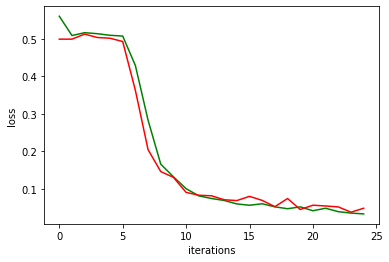

In [15]:
import matplotlib.pyplot as plt

iteration = np.arange(0., len(train_losses))
plt.plot(iteration, train_losses, 'g-',iteration, validation_losses, 'r-')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()
    


# Save/Load Model (given to you)

In [16]:
def save(model, train_losses, validation_losses, save_dir):
    """
    saving model, train losses, and validation losses
    Args:
        model              - NN to be saved
        train_losses       - history of losses for training dataset
        validation_losses  - history of losses for validation dataset
        save_dir           - directory where to save the above
    """
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    files = glob.glob(save_dir + '*')
    for f in files:
        os.remove(f) 
    
    
    torch.save(model, save_dir + "/model.dat")
    
    train_losses_f = open(save_dir + "/train_losses.txt", "wt")
    train_losses_f.writelines( "%.3f\n" % item for item in train_losses)
    
    validation_losses_f = open(save_dir + "/validation_losses.txt", "wt")
    validation_losses_f.writelines( "%.3f\n" % item for item in validation_losses)

    return
   

def load(save_dir):
    """
    loading model, train losses, and validation losses
    Args:
       save_dir  - dir name from where to load 
    """
    
    model = torch.load(save_dir + "/model.dat") 
    
    train_losses_f = open(save_dir + "/train_losses.txt", "rt")
    train_losses   = train_losses_f.readlines()
    train_losses   = [float(num) for num in train_losses]
    
    validation_losses_f = open(save_dir + "/validation_losses.txt", "rt")
    validation_losses   = validation_losses_f.readlines()
    validation_losses   = [float(num) for num in validation_losses]
    
    return (model, train_losses, validation_losses)
   

# Example saving and loading

In [17]:
# Create a directory, for example "./saves_12/", where you place your saved models

save(model, train_losses, validation_losses, "./saves/")

#model, train_losses, validation_losses = load("./saves_1/")

D:\ProgramData\Anaconda3\envs\deep_learning\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CircleNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\ProgramData\Anaconda3\envs\deep_learning\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\ProgramData\Anaconda3\envs\deep_learning\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Paint circles on loader images (given to you)

In [18]:
def paint_loader_circles(model, loader, out_dir):
    """
    This fucntion receives a model, a loader and an output directory. 
    For each image in the loader it paints a circle that the model identifies. 
    The images are saved in the given out_dir diretory. 
    Args:
        model   - network for idneitfying circles
        loader  - input data to use 
        out_dir - ouptut directory name (e.g.: 'draws/'). If directory does not exist, it is created.
                  If it exists, its files are deleted.
    """

    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
                  # (dropout is set to zero)

    k = 0
    
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    files = glob.glob(out_dir + '*')
    for f in files:
        os.remove(f) 
  
        
    for data in loader:
        # get inputs
        inputs = (data['image']).to(device)
        labels = (data['labels']).to(device)  # not using 
        img_fnames = data['fname'] 
      
        
        # forward
        outputs = model(inputs.float())
        curr_batch_size = np.shape(outputs)[0]
        image_size = np.shape(inputs[0])  # image_size = [3, w, h]
        _, width, height = image_size
        assert (width == height)
        
        for i in range (curr_batch_size): 
            x0 = (outputs[i, 0].item()) * width
            y0 = (1-outputs[i, 1].item()) * height
            r  = outputs[i, 2].item() * width #assume width=height here. Otherwise, circle becomes ellipse

            fname = img_fnames[i]
            k+=1
            print (str(k) + ".   " + fname)

            img = Image.open(fname)
            draw = ImageDraw.Draw(img, 'RGBA')
    
            draw.ellipse((x0 - r, y0 - r, x0 + r ,y0 + r), fill=(160, 64, 0, 90), outline=None)
    
            img.save(out_dir + fname.split('/')[-1])
    
        
    model.train()  #back to default
    return

# Example of how to paint circles produced by model

In [19]:
# Painting circles on images from validation loader and placing them in directory "./validation/draw/". 
# Notice that if the painted circle is seen only partly, it means that it is not inside the 
# [0,1]x[0,1] "box", which is the domain considered.  This means that your model has siginificant error


paint_loader_circles(model, validation_loader, './validation/draw/')

1.   ./validation//images/0000.png
2.   ./validation//images/0001.png
3.   ./validation//images/0002.png
4.   ./validation//images/0003.png
5.   ./validation//images/0004.png
6.   ./validation//images/0005.png
7.   ./validation//images/0006.png
8.   ./validation//images/0007.png
9.   ./validation//images/0008.png
10.   ./validation//images/0009.png
11.   ./validation//images/0010.png
12.   ./validation//images/0011.png
13.   ./validation//images/0012.png
14.   ./validation//images/0013.png
15.   ./validation//images/0014.png
16.   ./validation//images/0015.png
17.   ./validation//images/0016.png
18.   ./validation//images/0017.png
19.   ./validation//images/0018.png
20.   ./validation//images/0019.png
21.   ./validation//images/0020.png
22.   ./validation//images/0021.png
23.   ./validation//images/0022.png
24.   ./validation//images/0023.png
25.   ./validation//images/0024.png
26.   ./validation//images/0025.png
27.   ./validation//images/0026.png
28.   ./validation//images/0027.png
2